# **1. Import Required Libraries**

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Building and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error

# Model Saving
import joblib

# Warnings
import warnings
warnings.filterwarnings('ignore')


# **2. Load and Explore Dataset**

In [2]:
# Load the dataset
df = pd.read_csv('download.csv')

# Display the first few rows
print(df.head())

# Display basic information about the dataset
print(df.info())

# Summary Statistics
print(df.describe())


   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  
<class 'pandas.core.frame.

# Insights

## 1. **Check for Missing Values**
- Identify columns with missing data.
- Calculate the percentage of missing values per column.
- Determine if imputation or removal is necessary.

## 2. **Understand the Data Types of Each Column**
- Classify columns as numerical, categorical, or datetime.
- Ensure each column has the appropriate data type for analysis.

## 3. **Identify Columns Requiring Categorical Encoding**
- Detect non-numeric columns that need encoding (e.g., one-hot encoding, label encoding).
- Assess the number of unique values in each categorical column.
- Choose the appropriate encoding technique based on the cardinality of the column.


# **3. Data Preprocessing**

### **3.1 Handle Irrelevant Columns**

In [4]:
# Drop irrelevant columns
df = df.drop(['instant', 'dteday'], axis=1)

### **3.2 Handle Categorical Variables**

In [5]:
# Map season and weathersit to meaningful labels
df['season'] = df['season'].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
df['weathersit'] = df['weathersit'].map({
    1: 'Clear',
    2: 'Mist',
    3: 'LightSnow',
    4: 'HeavyRain'
})

# Create dummy variables for categorical features
df = pd.get_dummies(df, columns=['season', 'weathersit'], drop_first=True)

### **3.3 Drop Redundant Columns**

In [7]:
# Drop 'casual' and 'registered' as they contribute to 'cnt'
df = df.drop(['casual', 'registered'], axis=1)

### **3.4 Feature-Target Split**

In [8]:
# Define features (X) and target (y)
X = df.drop('cnt', axis=1)
y = df['cnt']

# Display the final dataset
print(X.head())
print(y.head())

   yr  mnth  holiday  weekday  workingday       temp     atemp      hum  \
0   0     1        0        6           0  14.110847  18.18125  80.5833   
1   0     1        0        0           0  14.902598  17.68695  69.6087   
2   0     1        0        1           1   8.050924   9.47025  43.7273   
3   0     1        0        2           1   8.200000  10.60610  59.0435   
4   0     1        0        3           1   9.305237  11.46350  43.6957   

   windspeed  season_spring  season_summer  season_winter  \
0  10.749882           True          False          False   
1  16.652113           True          False          False   
2  16.636703           True          False          False   
3  10.739832           True          False          False   
4  12.522300           True          False          False   

   weathersit_LightSnow  weathersit_Mist  
0                 False             True  
1                 False             True  
2                 False            False  
3         

# **4. Exploratory Data Analysis (EDA)**

### **4.1 Correlation Heatmap**

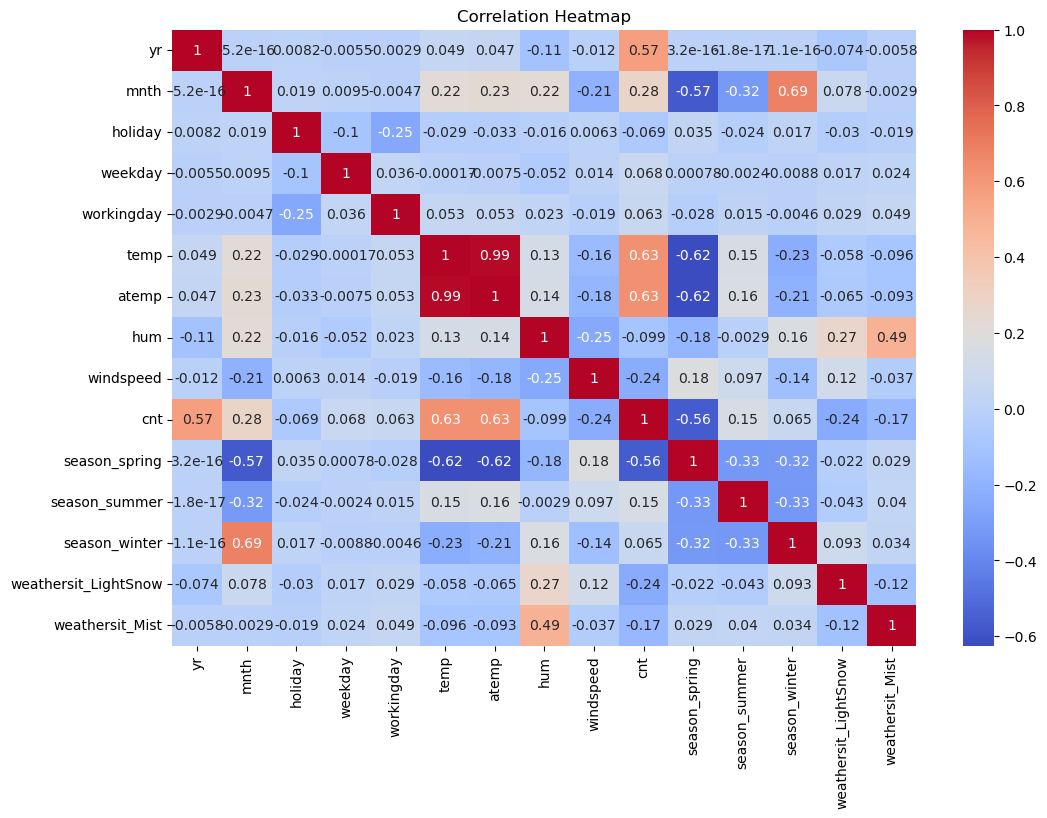

In [10]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### **4.2 Pair Plot**

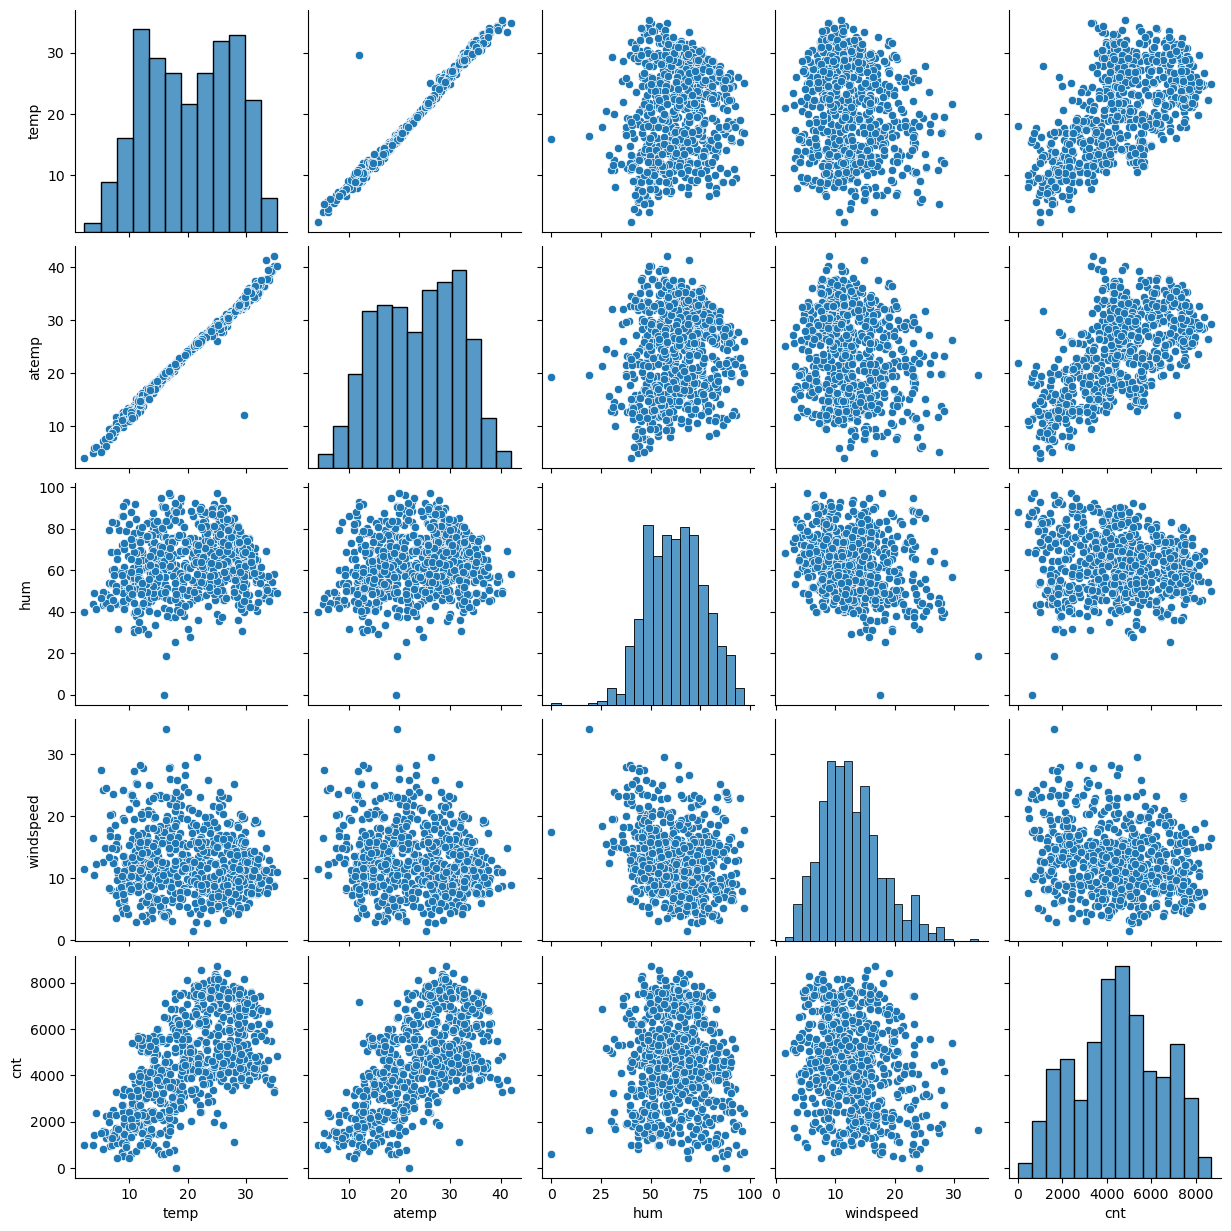

In [12]:
# Pairplot for key numeric variables
sns.pairplot(df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']])
plt.show()

### **4.3 Distribution of Target Variable**

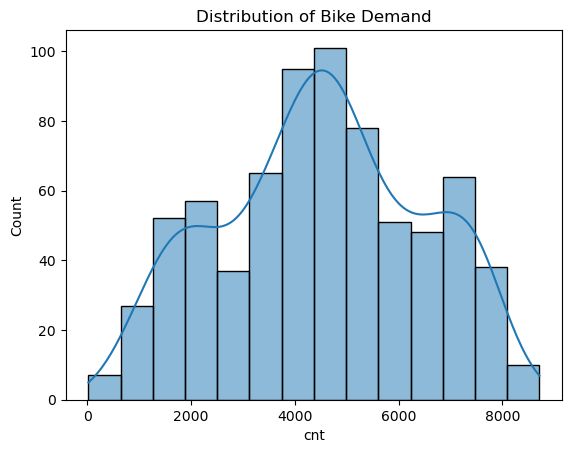

In [13]:
# Target Variable Distribution
sns.histplot(y, kde=True)
plt.title('Distribution of Bike Demand')
plt.show()

# **5. Train-Test Split**

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display Shapes
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (584, 14), Test set: (146, 14)


# **6. Feature Selection Using RFE (Recursive Feature Elimination)**

In [16]:
# Initialize Linear Regression model
lr = LinearRegression()

# Perform RFE to select top features
rfe = RFE(lr, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:\n", selected_features)

Selected Features:
 Index(['yr', 'holiday', 'weekday', 'workingday', 'temp', 'season_spring',
       'season_summer', 'season_winter', 'weathersit_LightSnow',
       'weathersit_Mist'],
      dtype='object')


### **6.1 Prepare Train and Test Sets with Selected Features**

In [18]:
# Filter selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# **7. Build and Train the Model**

In [19]:
# Train the model
lr.fit(X_train_rfe, y_train)

# Predict on training and test sets
y_train_pred = lr.predict(X_train_rfe)
y_test_pred = lr.predict(X_test_rfe)

# **8. Model Evaluation**

In [21]:
# Evaluate R-Squared
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Evaluate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train R² Score: {train_r2:.2f}")
print(f"Test R² Score: {test_r2:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

Train R² Score: 0.81
Test R² Score: 0.84
Train RMSE: 852.20
Test RMSE: 737.77


# Model Performance Evaluation and Explanation

## **1. Model Scores Overview**

- **Train R² Score:** 0.81  
   - The model explains **81%** of the variance in the training data, indicating good performance on known data.

- **Test R² Score:** 0.84  
   - The model explains **84%** of the variance in unseen test data, demonstrating strong generalization.

- **Train RMSE:** 852.20  
   - **Root Mean Squared Error (RMSE)** measures the average prediction error on the training set.  
   - A lower RMSE indicates accurate predictions on training data.

- **Test RMSE:** 737.77  
   - Measures prediction error on unseen data.  
   - The lower test RMSE indicates effective generalization and minimized prediction errors.

---

## **2. Key Terms Explained**

- **y_test:**  
   - Represents the **actual target values** from the test dataset.  
   - These are the real observed outcomes used to evaluate the model's predictions.

- **y_test_pred:**  
   - Represents the **predicted target values** generated by the model for the test dataset.  
   - These values are the model's estimates based on the test set features.

- **r2_score:**  
   - Measures the **proportion of variance in the dependent variable explained by the model**.  
   - Formula:  
     \[
     R^2 = 1 - \frac{\sum(y_{\text{test}} - y_{\text{test_pred}})^2}{\sum(y_{\text{test}} - \bar{y}_{\text{test}})^2}
     \]  
   - **Interpretation:**  
     - \( R^2 = 1 \): Perfect prediction.  
     - \( R^2 > 0.7 \): Good model fit.  
     - \( R^2 < 0 \): Poor model fit (worse than a simple mean predictor).

---

## **3. Insights and Conclusion**

- The model shows strong performance on both training and test datasets, with slightly better generalization on unseen data.
- The **R² scores** suggest that the model captures a high proportion of variance in the target variable.
- The **RMSE values** indicate a relatively low average prediction error, confirming reliable model performance.


### **8.1 Additional Model Metrics (Optional but Recommended)**

While R² is crucial, you can also evaluate the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) to gain more insights into the model's predictive performance.

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")


Test RMSE: 737.77
Test MAE: 567.50


# Model Performance Evaluation and Explanation

## **1. Model Metrics Overview**

- **Test RMSE:** 737.77  
   - **Root Mean Squared Error (RMSE)** measures the average magnitude of prediction errors.  
   - It represents the **standard deviation of the residuals** (prediction errors) and is expressed in the **same units as the target variable**.  
   - **Lower RMSE indicates better predictive accuracy.**

- **Test MAE:** 567.50  
   - **Mean Absolute Error (MAE)** calculates the average **absolute difference** between the actual and predicted values.  
   - It provides an intuitive measure of prediction error in the same units as the target variable.  
   - **Lower MAE indicates smaller prediction deviations on average.**

---

## **2. Key Terms Explained**

- **RMSE (Root Mean Squared Error):**  
   - Measures the **average magnitude of prediction errors** while giving **higher weight to larger errors**.  
   - Formula:  
     \[
     RMSE = \sqrt{\frac{\sum (y_{\text{test}} - y_{\text{test_pred}})^2}{n}}
     \]  
   - **Interpretation:** A smaller RMSE indicates the model's predictions are closer to the actual values.

- **MAE (Mean Absolute Error):**  
   - Measures the **average absolute difference** between predicted and actual values.  
   - Formula:  
     \[
     MAE = \frac{\sum |y_{\text{test}} - y_{\text{test_pred}}|}{n}
     \]  
   - **Interpretation:** MAE provides an intuitive understanding of average prediction error without amplifying larger deviations.

---

## **3. Insights and Conclusion**

- **RMSE (737.77)** indicates the average prediction error, penalizing larger deviations more heavily.  
- **MAE (567.50)** represents the average absolute error, providing a clear and interpretable measure of prediction accuracy.  
- Both metrics suggest the model performs effectively, with predictions closely aligned with actual values.  
- RMSE is typically higher than MAE because it squares the errors before averaging, emphasizing larger discrepancies.


### **8.2 Interpretation of Results**

# Model Evaluation Metrics

| **Metric** | **Ideal Value** | **Interpretation** |
|------------|------------------|--------------------|
| **R² Score** | Close to **1** | Higher is better; indicates the proportion of variance in the target variable explained by the model. |
| **RMSE**    | Lower value     | Measures the **average magnitude of prediction errors**; penalizes larger errors more heavily. |
| **MAE**     | Lower value     | Measures the **average absolute difference** between predicted and actual values; provides an intuitive error measure. |

---

## **Summary of Metrics**

- **R² Score:** Reflects the model's overall accuracy and its ability to explain variability in the target variable.  
- **RMSE:** Quantifies prediction error with a focus on penalizing larger deviations.  
- **MAE:** Offers a straightforward, easy-to-interpret measure of average prediction error without overemphasizing large errors.

**Ideal Scenario:** A model with an **R² Score close to 1**, and both **RMSE** and **MAE** as low as possible.


### **8.4. Visual Evaluation**

 #### **Actual vs Predicted Plot**

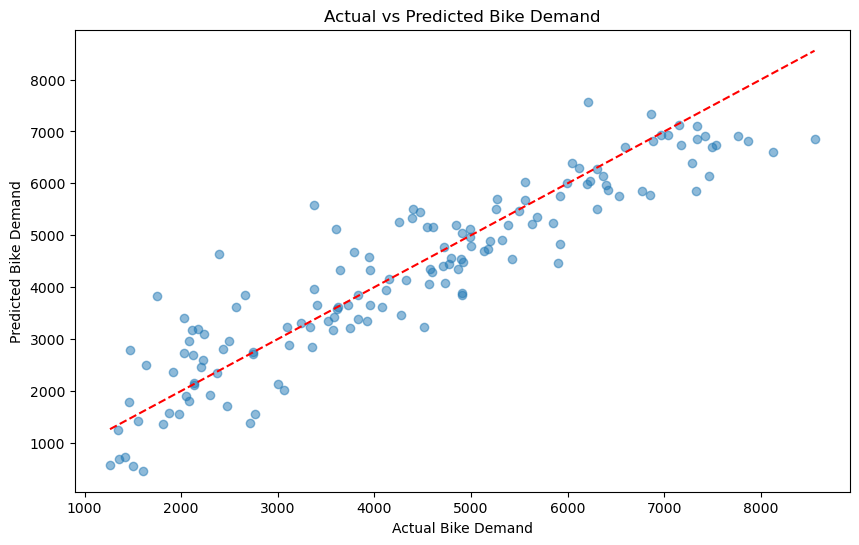

In [25]:
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Bike Demand')
plt.xlabel('Actual Bike Demand')
plt.ylabel('Predicted Bike Demand')
plt.show()


#### **Residual Plot**

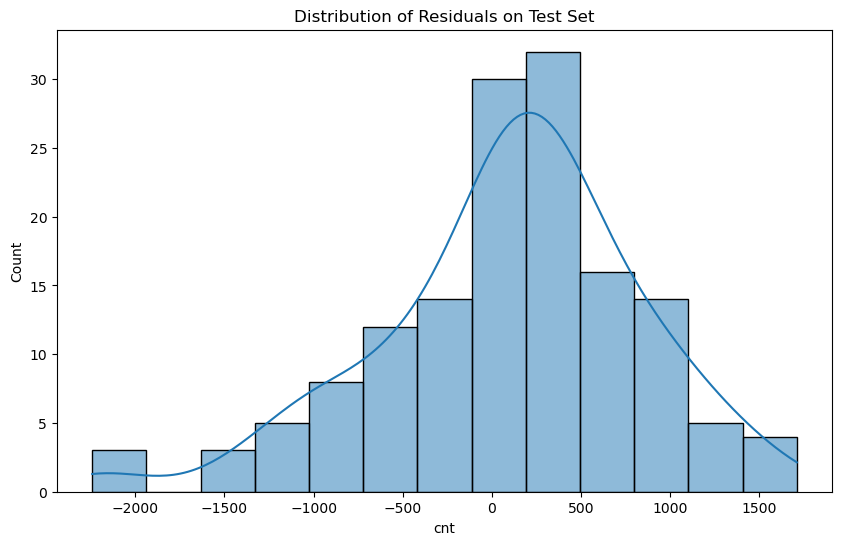

In [26]:
# Residuals Plot for Test Set
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals on Test Set')
plt.show()

### **8.5. Final Remarks**

# Model Evaluation Insights

## **1. Interpretation of Metrics**

- **R² Score (e.g., >0.8):**  
   - A high R² score indicates that the model captures **most of the variance** in the data.  
   - It suggests that the predictions closely follow the actual target values.

- **RMSE (Root Mean Squared Error):**  
   - A **lower RMSE** indicates smaller average prediction errors.  
   - It emphasizes larger errors by squaring them, making it sensitive to outliers.

- **MAE (Mean Absolute Error):**  
   - A **lower MAE** signifies smaller average absolute errors.  
   - It provides an intuitive measure of prediction accuracy without being overly influenced by large deviations.

---

## **2. Residual Analysis with Visual Plots**

- **Residual Plot:**  
   - Plot the **residuals (errors)** on the y-axis against the **predicted values** or **independent variables** on the x-axis.  
   - Residuals should appear **randomly distributed** around zero with no discernible patterns.  
   - A non-random pattern (e.g., funnel shape or curve) indicates model bias or an unmet assumption.

- **Key Indicators of a Well-Fitted Model from Residual Plots:**  
   - Residuals are evenly spread around the zero line.  
   - No visible structure or patterns (e.g., curves, clusters).  
   - Constant variance (homoscedasticity) across residuals.

---

## **3. Summary of Insights**

- A **high R² score (>0.8)** suggests the model effectively explains the variance in the target variable.  
- **Low RMSE and MAE** indicate a model with accurate predictions and minimal error.  
- **Residual plots** serve as a diagnostic tool to confirm that the model's assumptions hold and there are no systematic errors.

**Action Item:** Always validate performance metrics with **visual residual analysis** to ensure reliable model interpretation and robust predictions.


# **9. Model Insights**

In [27]:
# Display Coefficients
coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)

                Feature  Coefficient
0                    yr  2018.913551
7         season_winter   726.944179
6         season_summer   275.953536
3            workingday   157.586798
4                  temp   125.377815
2               weekday    75.287009
1               holiday  -500.355749
9       weathersit_Mist  -613.963153
5         season_spring  -858.262995
8  weathersit_LightSnow -2563.154831


# Key Insights from Model Coefficients

## **1. Most Significant Predictors of Bike Demand**

### **Top Positive Predictors (Increase Demand):**
- **yr (2018.91)**: Bike demand increases significantly with each passing year, indicating a long-term upward trend.
- **season_winter (726.94)**: Winter season has a positive association with bike demand, potentially driven by unique seasonal activities or promotions.
- **season_summer (275.95)**: Summer season also positively impacts demand, albeit to a lesser extent than winter.
- **workingday (157.59)**: Demand increases on working days, suggesting higher usage for commuting purposes.
- **temp (125.38)**: Higher temperatures moderately increase bike demand, likely due to more favorable biking conditions.

### **Top Negative Predictors (Decrease Demand):**
- **weathersit_LightSnow (-2563.15)**: Light snow drastically reduces bike demand, likely due to poor biking conditions and safety concerns.
- **season_spring (-858.26)**: Spring shows a negative effect, possibly indicating lower biking activity during this season.
- **weathersit_Mist (-613.96)**: Misty weather reduces bike demand, potentially due to visibility and safety issues.
- **holiday (-500.36)**: Holidays reduce bike demand, indicating fewer people commute by bike on non-working days.

---

## **2. Actionable Insights**

### **Increase Demand:**
- **Leverage Trends Over Time:** The significant positive effect of `yr` suggests continued growth in bike demand. City planners and bike-sharing services should continue expanding bike infrastructure to meet rising demand.
- **Seasonal Promotions:** Capitalize on the positive effect of **winter** and **summer** seasons by running seasonal promotions and offering incentives during these times.
- **Working Day Optimization:** Enhance bike availability and convenience on **working days** to support commuter traffic.

### **Mitigate Demand Drops:**
- **Weather Adaptations:** Severe negative impacts from **Light Snow** and **Mist** suggest a need for better infrastructure (e.g., snow-cleared bike lanes) and safety measures (e.g., better lighting in misty conditions).
- **Holiday Campaigns:** Introduce special offers or events on **holidays** to encourage bike use during non-working days.
- **Spring Demand Management:** Investigate why **spring** shows lower demand and address barriers, such as weather patterns or lack of targeted campaigns.

---

## **3. Summary of Insights**
- Long-term trends (`yr`) and seasonal effects (e.g., `season_winter`) are key drivers of demand.  
- Weather conditions (e.g., `weathersit_LightSnow`, `weathersit_Mist`) have significant negative impacts and require targeted interventio


# **10. Save Model and Selected Features**

In [28]:
# Save the Model
joblib.dump(lr, 'bike_demand_model.pkl')

# Save Selected Features
selected_features.to_series().to_csv('selected_features.csv', index=False)